# 베이스라인 모델

In [1]:
import xml.etree.ElementTree as elemTree
import os
import sys
tree = elemTree.parse(r'../config/.config.xml')
root = tree.getroot()
xx = root.find('./PATHS')
work_path = xx.find('work').text
sys.path.append(work_path)

In [2]:
import numpy
import talib
from miscs.config_manager import ConfigManager
import pandas as pd
from sqlalchemy import create_engine
from tqdm.auto import tqdm
from realtime_kiwoom.data_provider import *
import re
import numpy as np

In [3]:
cm = ConfigManager('../config/.config.xml')

# 데이터 로딩

In [4]:
history_provider = MinuteChartDataProvider.Factory(cm, tag='history')

In [5]:
%%time
history_minute_dic = history_provider.get_history_from_ndays_ago(n_days=365)

CPU times: total: 33.7 s
Wall time: 34.3 s


# 기술적 지표

MACD

RSI

AD Line

offset_intra_day
- 9시부터 15시30분사이에 오프셋이 차지하는 위치를 [0, 1] 사이의 값으로 표현

In [6]:
def make_basic_features(df: pd.DataFrame):
  """
  df가 변형됨
  """
  macd, macdsignal, macdhist = talib.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
  rsi = talib.RSI(df['close'], timeperiod=14)
  ad = talib.AD(df['high'], df['low'], df['close'], df['volume'])

  df['macd'] = macd
  df['macdsignal'] = macdsignal
  df['macdhist'] = macdhist
  df['rsi'] = rsi
  df['ad'] = ad

  df['offset_intra_day'] = ((df.index - df.index.floor('D') - pd.Timedelta('9h')).total_seconds()/(60*60*6.5)).values


윈도우 피쳐
- 각 컬럼 지표의 이동 평균값 / 현재 분의 지표로 하여 정규화한 피쳐를 사용

In [7]:
def make_window_features(df: pd.DataFrame, cols=['macd', 'macdsignal', 'macdhist', 'rsi', 'ad', 'close'], window_size=10):
  """
  df가 변형됨
  """
  for col in cols:
    df[f'{col}_w'] = df[col].rolling(window=window_size).mean() / df[col]

장 종료 / 장 시작 분에 해당하는지 
- 바이너리 피쳐

In [8]:
def make_binary_dt_features(df: pd.DataFrame):
  """
  df가 변형됨
  """
  ss = df.reset_index()
  ss.close
  df['ts_end'] = ss.dt.shift(-1).apply(lambda x: x.hour == 9 and x.minute == 0).values
  df['ts_start'] = ss.dt.apply(lambda x: x.hour == 9 and x.minute == 0).values

어제 종가 보다 오른 상태로 현재가가 형성되어 있는지
- 바이너리 피쳐

In [9]:
def make_binary_close_indicators(df: pd.DataFrame):
  """
  df가 변형됨: 현재 가격이 어제 종가보다 큰지?
  """
  dic = {name:group.iloc[-1].close for name, group in df.groupby(df.index.strftime('%Y-%m-%d'))}
  df['is_higher'] = pd.Series(df.index.strftime('%Y-%m-%d').map(dic).values, index=df.index).shift(1) < df.close
  

In [10]:
def make_binary_indicators(df: pd.DataFrame):
  make_binary_dt_features(df)
  make_binary_close_indicators(df)

In [11]:
def make_target(df: pd.DataFrame, window_size=10):
  """
  df가 변형됨
  close의 내일 ~ window_size 까지의 가격 변화율을 target으로 함
  """
  df['target'] = df.close.rolling(window=window_size).mean().shift(-window_size) /df.close

In [12]:
for code, df in history_minute_dic.items():
  make_basic_features(df)
for code, df in history_minute_dic.items():
  make_window_features(df)
for code, df in history_minute_dic.items():
  make_binary_indicators(df)
for code, df in history_minute_dic.items():
  make_target(df, window_size=60)

타겟이 현재를 보지 않은 것인지 검증

In [23]:
window_size=60
a0 = df.close
a1 = df.close.rolling(window_size).mean().rename('ma')
a2 = df.close.rolling(window_size).mean().shift(-window_size).rename('shifted')
yy = pd.concat((a0, a1, a2), axis=1)[-200:]
assert(yy.iloc[window_size].ma == yy.iloc[0].shifted)

아래의 컬럼 지표를 활용한다.

In [24]:
new_cols = ['macd_w', 'macdsignal_w', 'macdhist_w', 'rsi_w', 'ad_w', 'close_w', 'ts_end', 'ts_start', 'is_higher', 'offset_intra_day', 'target']

In [25]:
compact_minute_dic = {code:df[new_cols] for code, df in history_minute_dic.items()}

In [26]:
merged_df = pd.merge(compact_minute_dic['069500'], compact_minute_dic['114800'], left_index=True, right_index=True, suffixes=('_x', '_y'))

In [27]:
merged_df['label'] = 'NOP'
merged_df.loc[(merged_df.target_x > merged_df.target_y) & (merged_df.target_x > 1.001) & (merged_df.target_y < 0.999), 'label'] = 'X'
merged_df.loc[(merged_df.target_x < merged_df.target_y) & (merged_df.target_x < 0.999) & (merged_df.target_y > 1.001), 'label'] = 'Y'
merged_df['label'] = merged_df.label.astype('category')

편의를 위해 pkl 저장

In [ ]:
merged_df.to_pickle('.merged_for_baseline_df.pkl')

yy.label.cat.codes
- category 를 숫자 코드 값으로 조회 가능

# FLAML

AUTO ML 로서 lightgbm 의 최적 학습 결과를 찾는다.

저장된 데이터 로딩
- dropna() : 결측치 제거
- target_x, target_y 제거

In [28]:
merged_df = pd.read_pickle('.merged_for_baseline_df.pkl').dropna(axis=0).drop(columns=['target_x', 'target_y'])

In [29]:
import ray
from flaml import AutoML

C:\Users\rupin\AppData\Roaming\Python\Python38\site-packages\flaml\searcher\blendsearch.py:14: DeprecationWarning: The module `ray.tune.suggest` has been moved to `ray.tune.search` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest` with `ray.tune.search`.
  from ray.tune.suggest import Searcher
C:\Users\rupin\AppData\Roaming\Python\Python38\site-packages\flaml\searcher\blendsearch.py:15: DeprecationWarning: The module `ray.tune.suggest.optuna` has been moved to `ray.tune.search.optuna` and the old location will be deprecated soon. Please adjust your imports to point to the new location. Example: Do a global search and replace `ray.tune.suggest.optuna` with `ray.tune.search.optuna`.
  from ray.tune.suggest.optuna import OptunaSearch as GlobalSearch
C:\Users\rupin\AppData\Roaming\Python\Python38\site-packages\flaml\tune\__init__.py:5: DeprecationWarning: The module `ray.tune.sam

In [30]:
automl = AutoML()

In [31]:
ray.init(num_cpus=4)

2022-10-07 13:59:26,395	INFO worker.py:1518 -- Started a local Ray instance.


Python version:,3.8.13
Ray version:,2.0.0


In [32]:
from sktime.forecasting.model_selection import temporal_train_test_split

스플릿
- 학습 (검증 포함): ~ 2020-07-31
- 테스트: 2022-08-01 ~ 2022-09-29 (30일의 경우는 미래 타겟을 계산할 수 없는 구간이 있어 29일까지로 함)

In [33]:

learn_split = merged_df.loc[:'2022-07-31']
test_split = merged_df.loc['2022-08-01':]

학습 데이터를 다시 학습(train)/검증(validation)으로 분할 8:2 

In [34]:
X_train, X_val = temporal_train_test_split(learn_split, test_size=0.2)
X_test = test_split

In [35]:
y_train = X_train.pop('label')
y_val = X_val.pop('label')
y_test = X_test.pop('label')

In [ ]:
automl.fit(X_train, y_train, task="classification", X_val=X_val, y_val=y_val, time_budget=1800, n_jobs=4, n_concurrent_trials=1, log_file_name='.segment_automl_0.5h.log', estimator_list=["lgbm"])

In [36]:
'''pickle and save the automl object'''
import pickle
# with open('.automl_0.5.pkl', 'wb') as f:
#     pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('.automl_0.5.pkl', 'rb') as f:
    automl = pickle.load(f)

베스트 모델 구조

In [37]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best loss on validation data: {0:.4g}'.format(automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 44, 'num_leaves': 5, 'min_child_samples': 4, 'learning_rate': 0.37978785707535195, 'log_max_bin': 7, 'colsample_bytree': 0.9069155047998616, 'reg_alpha': 0.020266149452080568, 'reg_lambda': 3.187904635266289, 'FLAML_sample_size': 61948}
Best loss on validation data: 0.9419
Training duration of best run: 0.3886 s


In [ ]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

In [39]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))

accuracy = 0.6206593957628181


In [40]:
pd.Series(y_pred).value_counts(normalize=True)

NOP    0.730663
Y      0.161527
X      0.107810
dtype: float64

In [41]:
y_test.value_counts(normalize=True)

NOP    0.583991
Y      0.221637
X      0.194371
Name: label, dtype: float64

 AUTO ML 탐색 커브

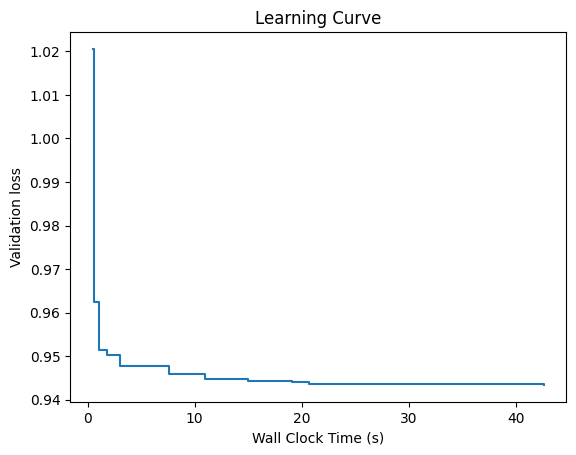

In [42]:
from flaml.data import get_output_from_log
import matplotlib.pyplot as plt
import numpy as np

time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename='.segment_automl_0.5h.log', time_budget=60)

plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation loss")
plt.step(time_history, np.array(best_valid_loss_history), where="post")
plt.show()

학습에 영향력이 큰 피쳐

<AxesSubplot: >

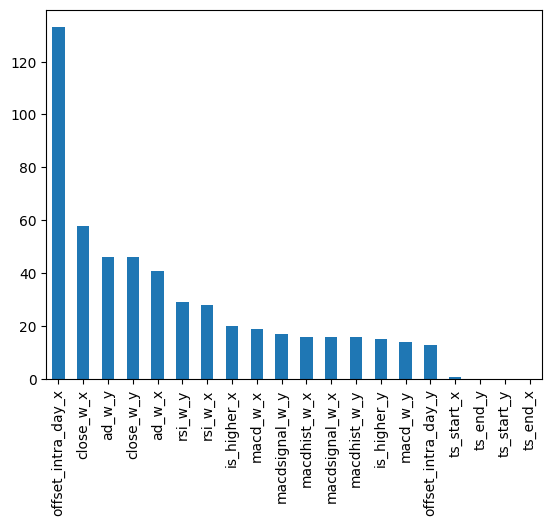

In [43]:
pd.Series(automl.feature_importances_, index=automl.feature_names_in_).sort_values(ascending=False).plot.bar()

In [44]:
from sklearn.metrics import classification_report

In [45]:
report = classification_report(y_test, y_pred)

In [46]:
print(report)

              precision    recall  f1-score   support

         NOP       0.68      0.85      0.76      9317
           X       0.46      0.26      0.33      3101
           Y       0.46      0.34      0.39      3536

    accuracy                           0.62     15954
   macro avg       0.53      0.48      0.49     15954
weighted avg       0.59      0.62      0.59     15954



예측 결과 저장

In [ ]:
pd.Series(y_pred, index=y_test.index).astype('category').to_pickle('.y_pred.pkl')